# Transformer Encoder-Only para Clasificación de Video (G8.0) - Sequential Embeddings

**Objetivo:** Clasificación de secuencias temporales con Transformer encoder-only usando embeddings secuenciales
**Dataset:** 868 videos, 96 frames, 128 features por frame (Sequential embeddings)
**Clases:** 30 (ASL - American Sign Language)
**Hardware:** RTX 5050 Laptop (8GB)

In [99]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, 
    classification_report, top_k_accuracy_score
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: NVIDIA GeForce GTX 1660 SUPER
VRAM: 6.44 GB


In [100]:
# 1. CARGAR DATASET EMBEDDINGS SECUENCIALES
dataset_path = Path('./daataset/dataset_embeddings_seq.npz')
data = np.load(dataset_path, allow_pickle=True)

X = data['X']  # (868, 96, 128) - Sequential embeddings
y = data['y']  # (868,)
masks = data['masks']  # (868, 96) - máscara por muestra
class_names = data['class_names']  # (30,)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Class names: {len(class_names)}")
print(f"Classes: {len(np.unique(y))}")
print(f"Unique classes: {np.unique(y)}")

# Información de las clases
unique_classes, class_counts = np.unique(y, return_counts=True)
print(f"\nDistribución de clases:")
for cls, count in zip(unique_classes, class_counts):
    print(f"  Clase {cls}: {count} muestras")

Dataset shape: X=(868, 96, 128), y=(868,)
Masks shape: (868, 96)
Class names: 30
Classes: 30
Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

Distribución de clases:
  Clase 0: 78 muestras
  Clase 1: 10 muestras
  Clase 2: 22 muestras
  Clase 3: 22 muestras
  Clase 4: 18 muestras
  Clase 5: 18 muestras
  Clase 6: 28 muestras
  Clase 7: 18 muestras
  Clase 8: 22 muestras
  Clase 9: 16 muestras
  Clase 10: 12 muestras
  Clase 11: 18 muestras
  Clase 12: 28 muestras
  Clase 13: 24 muestras
  Clase 14: 28 muestras
  Clase 15: 18 muestras
  Clase 16: 18 muestras
  Clase 17: 82 muestras
  Clase 18: 76 muestras
  Clase 19: 18 muestras
  Clase 20: 28 muestras
  Clase 21: 18 muestras
  Clase 22: 18 muestras
  Clase 23: 22 muestras
  Clase 24: 18 muestras
  Clase 25: 68 muestras
  Clase 26: 22 muestras
  Clase 27: 64 muestras
  Clase 28: 18 muestras
  Clase 29: 18 muestras


In [101]:
# 2. DATASET PYTORCH
class VideoTransformerDataset(Dataset):
    def __init__(self, X, y, masks):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.masks = torch.BoolTensor(masks)  # True = válido, False = padding
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.X[idx],      # (96, 128)
            'label': self.y[idx],          # scalar
            'mask': self.masks[idx]        # (96,)
        }

# Train-test split (80-20)
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    X, y, masks, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val, masks_train, masks_val = train_test_split(
    X_train, y_train, masks_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# DataLoaders
batch_size = 8
train_dataset = VideoTransformerDataset(X_train, y_train, masks_train)
val_dataset = VideoTransformerDataset(X_val, y_val, masks_val)
test_dataset = VideoTransformerDataset(X_test, y_test, masks_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Train: (555, 96, 128), Val: (139, 96, 128), Test: (174, 96, 128)
Batches - Train: 70, Val: 18, Test: 22


In [102]:
# 3. ARCHITECTURE: TRANSFORMER ENCODER-ONLY
class LearnablePositionalEncoding(nn.Module):
    """Positional encoding aprendible"""
    def __init__(self, d_model, max_len=96):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model))
        nn.init.normal_(self.pe, mean=0, std=0.02)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerEncoderOnlyClassifier(nn.Module):
    """
    Transformer Encoder-Only para clasificación de secuencias temporales
    - NO usa decoder
    - Usa masked mean pooling
    - Clasificación global por secuencia
    """
    def __init__(
        self,
        input_dim=128,
        d_model=256,
        num_heads=4,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.1,
        num_classes=30,
        max_seq_len=96,
        mlp_dropout=0.2,
        activation='gelu'
    ):
        super().__init__()
        
        self.d_model = d_model
        
        # 1. Proyección inicial (128 → 256)
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # 2. Positional Encoding aprendible
        self.pos_encoding = LearnablePositionalEncoding(d_model, max_seq_len)
        self.dropout = nn.Dropout(dropout)
        
        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        # 4. Classification Head (MLP: 256 → 128 → num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, src, src_key_padding_mask=None):
        """
        Args:
            src: (batch_size, seq_len, input_dim) = (B, 96, 128)
            src_key_padding_mask: (batch_size, seq_len) = True para padding
        Returns:
            logits: (batch_size, num_classes)
        """
        # 1. Proyección inicial
        x = self.input_projection(src)  # (B, 96, 256)
        
        # 2. Positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # 3. Transformer encoder con máscara
        x = self.transformer_encoder(
            x,
            src_key_padding_mask=src_key_padding_mask
        )  # (B, 96, 256)
        
        # 4. Masked mean pooling (solo frames válidos)
        if src_key_padding_mask is not None:
            # src_key_padding_mask: True = padding (ignorar)
            # Convertir a float: 0 para padding, 1 para válido
            mask_float = (~src_key_padding_mask).float().unsqueeze(-1)  # (B, 96, 1)
            x_masked = x * mask_float  # (B, 96, 256)
            sum_masked = x_masked.sum(dim=1)  # (B, 256)
            count_valid = mask_float.sum(dim=1)  # (B, 1)
            x_pooled = sum_masked / (count_valid + 1e-9)  # (B, 256)
        else:
            # Sin máscara: mean pooling simple
            x_pooled = x.mean(dim=1)  # (B, 256)
        
        # 5. Clasificador
        logits = self.classifier(x_pooled)  # (B, num_classes)
        
        return logits

# Crear modelo
num_classes = len(np.unique(y))
model = TransformerEncoderOnlyClassifier(
    input_dim=128,  # Sequential embeddings
    d_model=256,
    num_heads=4,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1,
    num_classes=num_classes,
    max_seq_len=96,
    mlp_dropout=0.2,
    activation='gelu'
).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModelo:")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print(model)


Modelo:
Total params: 2,203,294
Trainable params: 2,203,294
TransformerEncoderOnlyClassifier(
  (input_projection): Linear(in_features=128, out_features=256, bias=True)
  (pos_encoding): LearnablePositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((256

In [103]:
# 4. ENTRENAMIENTO - CONFIG
config = {
    'optimizer': 'AdamW',
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'loss': 'CrossEntropyLoss',
    'label_smoothing': 0.1,
    'batch_size': 8,
    'max_epochs': 50,
    'early_stopping_patience': 8,
    'gradient_clip': 1.0,
    'num_classes': num_classes,
    'input_dim': 128,
    'dataset_type': 'Sequential Embeddings',
    'device': str(device)
}

# Loss con label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay']
)

# LR Scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=1, eta_min=1e-6
)

print("Configuración de entrenamiento:")
for k, v in config.items():
    print(f"  {k}: {v}")

Configuración de entrenamiento:
  optimizer: AdamW
  lr: 0.0001
  weight_decay: 0.0001
  loss: CrossEntropyLoss
  label_smoothing: 0.1
  batch_size: 8
  max_epochs: 50
  early_stopping_patience: 8
  gradient_clip: 1.0
  num_classes: 30
  input_dim: 128
  dataset_type: Sequential Embeddings
  device: cuda


In [104]:
# 5. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
def train_epoch(model, loader, criterion, optimizer, device, grad_clip=1.0):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Train", leave=False):
        sequences = batch['sequence'].to(device)  # (B, 96, 128)
        labels = batch['label'].to(device)        # (B,)
        masks = batch['mask'].to(device)          # (B, 96)
        
        # Forward
        logits = model(sequences, src_key_padding_mask=~masks)
        loss = criterion(logits, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_logits = []
    
    for batch in tqdm(loader, desc="Eval", leave=False):
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        
        logits = model(sequences, src_key_padding_mask=~masks)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_logits.extend(logits.cpu().numpy())
    
    epoch_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_logits)

print("Funciones de entrenamiento definidas ✓")

Funciones de entrenamiento definidas ✓


In [ ]:
# 6. ENTRENAMIENTO PRINCIPAL
training_log = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_epoch = 0
patience_counter = 0
max_epochs = config['max_epochs']
early_stopping_patience = config['early_stopping_patience']

# Crear directorio para guardar modelos
Path('./g8.0_embeddings').mkdir(exist_ok=True)

print(f"\n{'='*80}")
print(f"Iniciando entrenamiento - Epoch max: {max_epochs}, Patience: {early_stopping_patience}")
print(f"{'='*80}\n")

for epoch in range(max_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Val
    val_loss, val_acc, _, _, _ = eval_epoch(model, val_loader, criterion, device)
    
    # LR Scheduler
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    
    # Log
    training_log['epoch'].append(epoch)
    training_log['train_loss'].append(train_loss)
    training_log['train_acc'].append(train_acc)
    training_log['val_loss'].append(val_loss)
    training_log['val_acc'].append(val_acc)
    training_log['lr'].append(current_lr)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        patience_counter = 0
        # Guardar mejor modelo
        best_model_path = Path('./g8.0_embeddings/best_model.pt')
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
    
    # Print
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{max_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")
    
    # Early stopping trigger
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Cargar mejor modelo
model.load_state_dict(torch.load(best_model_path, map_location=device))
print(f"\nMejor modelo cargado desde epoch {best_epoch} con Val Acc: {best_val_acc:.4f}")


Iniciando entrenamiento - Epoch max: 50, Patience: 8



Epoch   1/50 | Train Loss: 3.1429 | Train Acc: 0.2342 | Val Loss: 2.8510 | Val Acc: 0.3381 | LR: 1.00e-04


Epoch   5/50 | Train Loss: 1.9302 | Train Acc: 0.5405 | Val Loss: 1.8866 | Val Acc: 0.5468 | LR: 6.58e-05


Epoch  10/50 | Train Loss: 1.6698 | Train Acc: 0.6450 | Val Loss: 1.7090 | Val Acc: 0.6403 | LR: 3.42e-06


Epoch  15/50 | Train Loss: 1.2641 | Train Acc: 0.8288 | Val Loss: 1.2494 | Val Acc: 0.8633 | LR: 6.58e-05


Epoch  20/50 | Train Loss: 1.1030 | Train Acc: 0.9063 | Val Loss: 1.1532 | Val Acc: 0.8777 | LR: 3.42e-06


Epoch  25/50 | Train Loss: 0.9295 | Train Acc: 0.9604 | Val Loss: 0.9769 | Val Acc: 0.9281 | LR: 6.58e-05


Epoch  30/50 | Train Loss: 0.8627 | Train Acc: 0.9856 | Val Loss: 0.9407 | Val Acc: 0.9281 | LR: 3.42e-06


Train:  40%|████      | 28/70 [00:00<00:00, 61.96it/s]

In [ ]:
# 7. EVALUACIÓN EN TEST SET
print("Evaluando en Test Set...")
test_loss, test_acc, test_preds, test_labels, test_logits = eval_epoch(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Métricas adicionales
macro_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)
top3_acc = top_k_accuracy_score(test_labels, test_logits, k=3, labels=np.arange(num_classes))

print(f"Macro-F1: {macro_f1:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")

# F1 por clase
f1_per_class = f1_score(test_labels, test_preds, average=None, zero_division=0)
print(f"\nF1 Score por clase (primeras 5 clases):")
for i in range(min(5, num_classes)):
    print(f"  Clase {i}: {f1_per_class[i]:.4f}")

# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
print(f"\nMatriz de confusión shape: {cm.shape}")

Evaluando en Test Set...



Test Loss: 0.8633
Test Accuracy: 0.9540
Macro-F1: 0.9404
Top-3 Accuracy: 0.9828

F1 Score por clase (primeras 5 clases):
  Clase 0: 1.0000
  Clase 1: 1.0000
  Clase 2: 1.0000
  Clase 3: 1.0000
  Clase 4: 1.0000

Matriz de confusión shape: (30, 30)


In [ ]:
# 8. GUARDAR RESULTADOS
output_dir = Path('./g8.0_embeddings/')
output_dir.mkdir(exist_ok=True)

# 8.1 Training Log CSV
df_training = pd.DataFrame(training_log)
training_log_path = output_dir / 'training_log_g8.0.csv'
df_training.to_csv(training_log_path, index=False)
print(f"✓ Guardado: {training_log_path}")

# 8.2 Results CSV
results = {
    'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc, macro_f1, top3_acc, test_loss]
}
df_results = pd.DataFrame(results)
results_path = output_dir / 'results_g8.0.csv'
df_results.to_csv(results_path, index=False)
print(f"✓ Guardado: {results_path}")

# 8.3 Per-class metrics CSV
class_report = classification_report(
    test_labels, test_preds, 
    output_dict=True, 
    zero_division=0
)
df_per_class = pd.DataFrame(class_report).T
per_class_path = output_dir / 'per_class_g8.0.csv'
df_per_class.to_csv(per_class_path)
print(f"✓ Guardado: {per_class_path}")

# 8.4 Confusion Matrix CSV
cm_df = pd.DataFrame(cm)
confusion_path = output_dir / 'confusion_g8.0.csv'
cm_df.to_csv(confusion_path, index=False, header=False)
print(f"✓ Guardado: {confusion_path}")

# 8.5 Model Config JSON
model_config = {
    'architecture': 'TransformerEncoderOnly',
    'input_dim': 128,
    'd_model': 256,
    'num_heads': 4,
    'num_layers': 4,
    'dim_feedforward': 512,
    'dropout': 0.1,
    'num_classes': num_classes,
    'max_seq_len': 96,
    'mlp_dropout': 0.2,
    'activation': 'gelu',
    'total_params': total_params,
    'trainable_params': trainable_params,
}

model_config.update(config)
model_config['best_epoch'] = int(best_epoch)
model_config['best_val_acc'] = float(best_val_acc)
model_config['test_accuracy'] = float(test_acc)
model_config['test_macro_f1'] = float(macro_f1)
model_config['test_top3_accuracy'] = float(top3_acc)
model_config['training_timestamp'] = datetime.now().isoformat()

config_path = output_dir / 'model_config_g8.0.json'
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"✓ Guardado: {config_path}")

# 8.6 Model Weights
weights_path = output_dir / 'model_weights_g8.0.pt'
torch.save(model.state_dict(), weights_path)
print(f"✓ Guardado: {weights_path}")

print(f"\n{'='*80}")
print(f"RESULTADOS FINALES - TRANSFORMER ENCODER-ONLY (SEQUENTIAL EMBEDDINGS)")
print(f"{'='*80}")
print(f"Accuracy:       {test_acc:.4f}")
print(f"Macro-F1:       {macro_f1:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Best Epoch:     {best_epoch}")
print(f"Total Params:   {total_params:,}")
print(f"{'='*80}")

✓ Guardado: g8.0_embeddings\training_log_g8.0.csv
✓ Guardado: g8.0_embeddings\results_g8.0.csv
✓ Guardado: g8.0_embeddings\per_class_g8.0.csv
✓ Guardado: g8.0_embeddings\confusion_g8.0.csv
✓ Guardado: g8.0_embeddings\model_config_g8.0.json
✓ Guardado: g8.0_embeddings\model_weights_g8.0.pt

RESULTADOS FINALES - TRANSFORMER ENCODER-ONLY (SEQUENTIAL EMBEDDINGS)
Accuracy:       0.9540
Macro-F1:       0.9404
Top-3 Accuracy: 0.9828
Test Loss:      0.8633
Best Epoch:     35
Total Params:   2,203,294


✓ Guardado: g8.0_embeddings\training_curves_g8.0.png


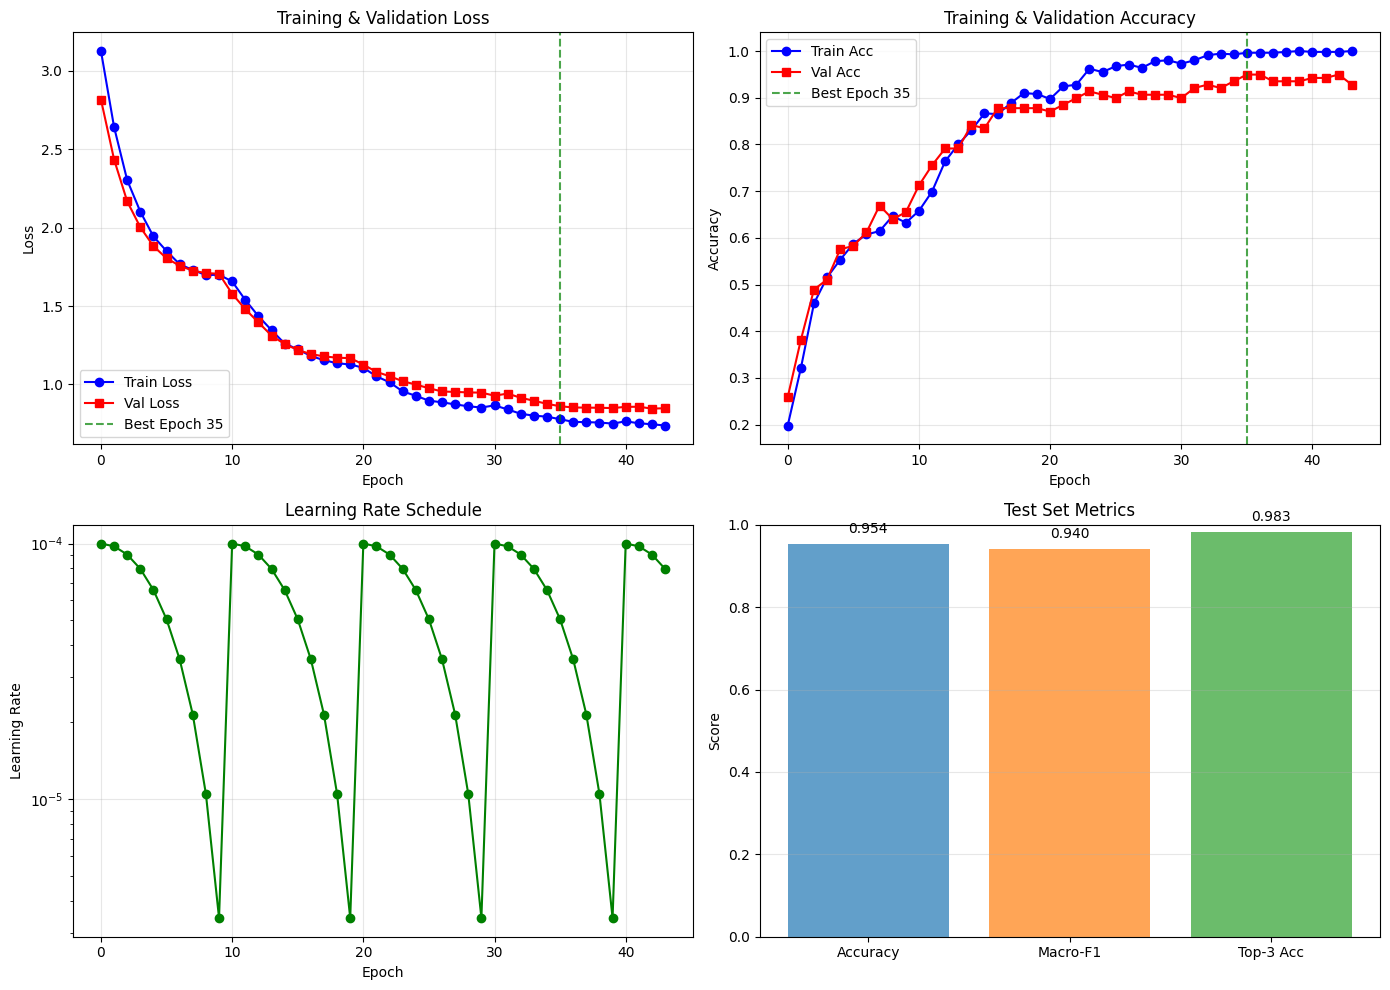

✓ Visualizaciones completadas


In [ ]:
# 9. VISUALIZACIONES
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 9.1 Training Loss
axes[0, 0].plot(training_log['epoch'], training_log['train_loss'], 'b-', label='Train Loss', marker='o')
axes[0, 0].plot(training_log['epoch'], training_log['val_loss'], 'r-', label='Val Loss', marker='s')
axes[0, 0].axvline(best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch {best_epoch}')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 9.2 Training Accuracy
axes[0, 1].plot(training_log['epoch'], training_log['train_acc'], 'b-', label='Train Acc', marker='o')
axes[0, 1].plot(training_log['epoch'], training_log['val_acc'], 'r-', label='Val Acc', marker='s')
axes[0, 1].axvline(best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch {best_epoch}')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 9.3 Learning Rate
axes[1, 0].plot(training_log['epoch'], training_log['lr'], 'g-', marker='o')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 9.4 Test Metrics
metrics_names = ['Accuracy', 'Macro-F1', 'Top-3 Acc']
metrics_values = [test_acc, macro_f1, top3_acc]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.7)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Test Set Metrics')
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(metrics_values):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plot_path = output_dir / 'training_curves_g8.0.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Guardado: {plot_path}")
plt.show()

print("✓ Visualizaciones completadas")

✓ Guardado: g8.0_embeddings\confusion_matrix_g8.0.png


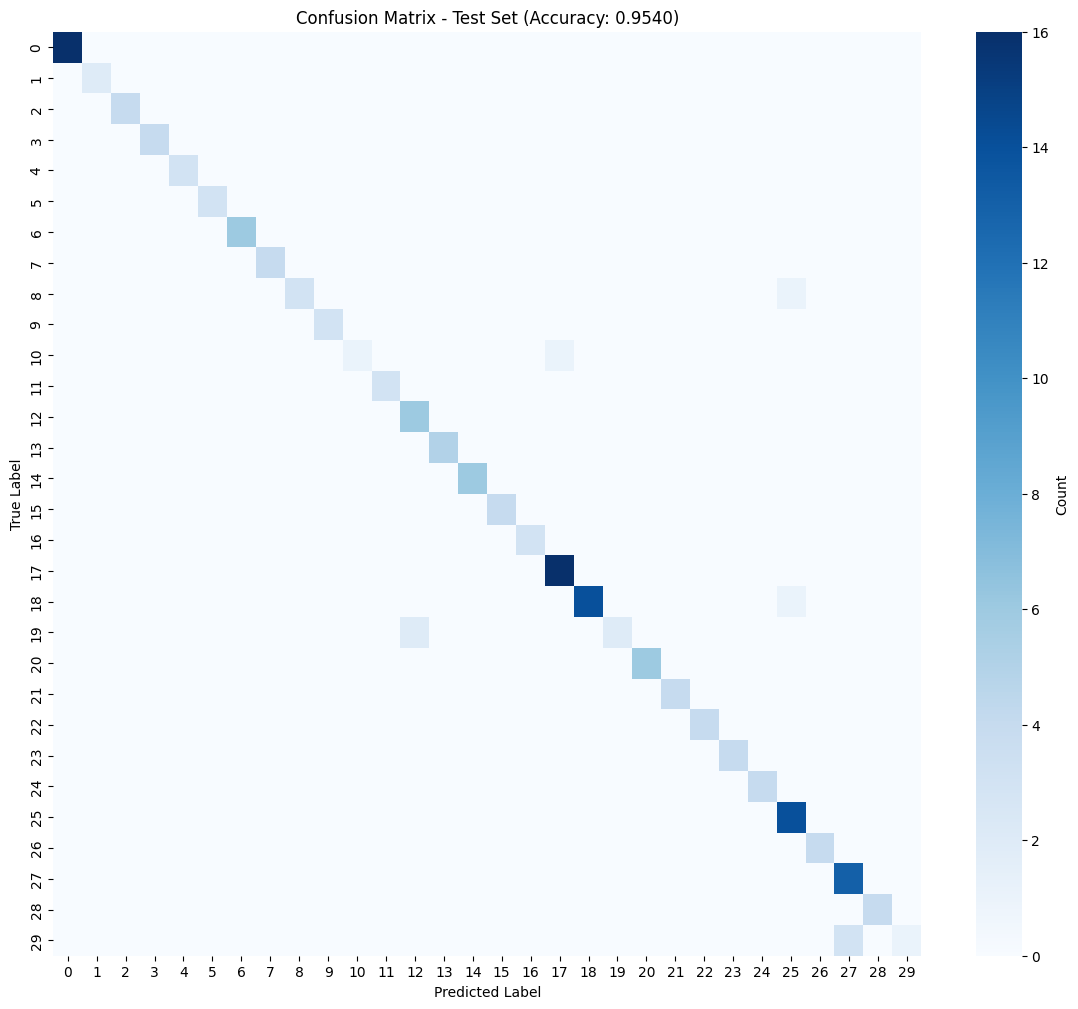


✓ Matriz de confusión completada


In [ ]:
# 10. CONFUSION MATRIX PLOT
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Confusion Matrix - Test Set (Accuracy: {test_acc:.4f})')

cm_plot_path = output_dir / 'confusion_matrix_g8.0.png'
plt.savefig(cm_plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Guardado: {cm_plot_path}")
plt.show()

print("\n✓ Matriz de confusión completada")

✓ Guardado: g8.0_embeddings\per_class_analysis_g8.0.png


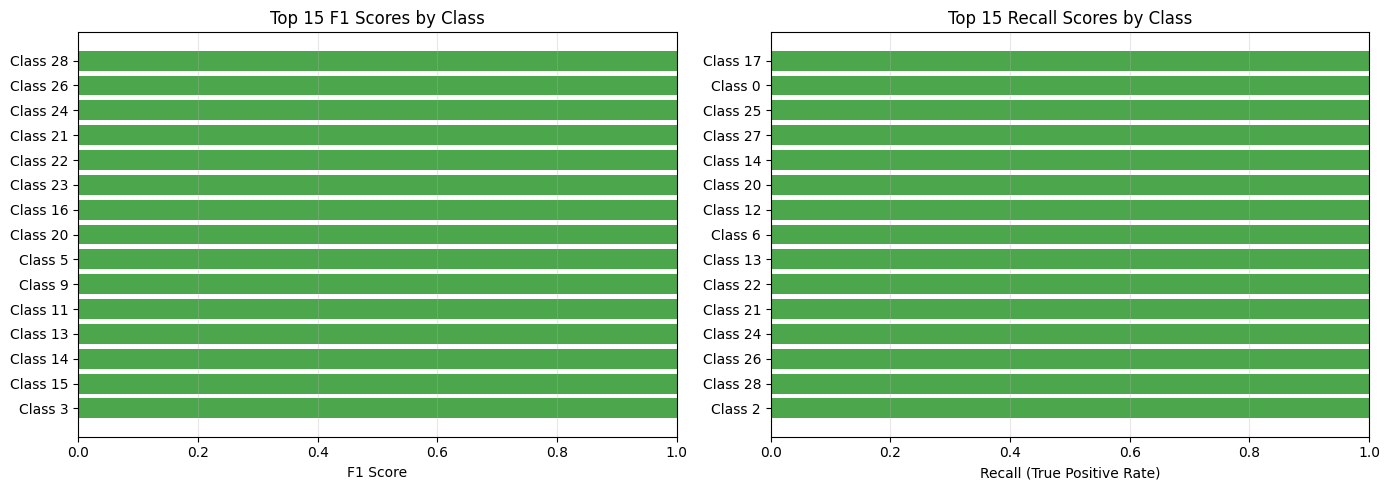

✓ Análisis por clase completado


In [ ]:
# 11. PER-CLASS ANALYSIS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 por clase (top 15)
top_k = 15
f1_indices = np.argsort(f1_per_class)[-top_k:]
top_f1 = f1_per_class[f1_indices]
colors_f1 = ['g' if v > 0.5 else 'orange' if v > 0.3 else 'r' for v in top_f1]

axes[0].barh(range(len(top_f1)), top_f1, color=colors_f1, alpha=0.7)
axes[0].set_yticks(range(len(top_f1)))
axes[0].set_yticklabels([f'Class {i}' for i in f1_indices])
axes[0].set_xlabel('F1 Score')
axes[0].set_title(f'Top {top_k} F1 Scores by Class')
axes[0].set_xlim([0, 1])
axes[0].grid(True, alpha=0.3, axis='x')

# Recall por clase (top 15)
recall_per_class = np.diag(cm) / (cm.sum(axis=1) + 1e-9)
recall_indices = np.argsort(recall_per_class)[-top_k:]
top_recall = recall_per_class[recall_indices]
colors_recall = ['g' if v > 0.5 else 'orange' if v > 0.3 else 'r' for v in top_recall]

axes[1].barh(range(len(top_recall)), top_recall, color=colors_recall, alpha=0.7)
axes[1].set_yticks(range(len(top_recall)))
axes[1].set_yticklabels([f'Class {i}' for i in recall_indices])
axes[1].set_xlabel('Recall (True Positive Rate)')
axes[1].set_title(f'Top {top_k} Recall Scores by Class')
axes[1].set_xlim([0, 1])
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
per_class_plot_path = output_dir / 'per_class_analysis_g8.0.png'
plt.savefig(per_class_plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Guardado: {per_class_plot_path}")
plt.show()

print("✓ Análisis por clase completado")

In [ ]:
# 12. RESUMEN FINAL
summary = f"""
{'='*80}
RESUMEN EJECUTIVO - TRANSFORMER ENCODER-ONLY CON SEQUENTIAL EMBEDDINGS
{'='*80}

📊 PERFORMANCE:
  • Test Accuracy:       {test_acc:.4f}
  • Macro F1-Score:      {macro_f1:.4f}
  • Top-3 Accuracy:      {top3_acc:.4f}
  • Test Loss:           {test_loss:.4f}

🏗️ ARQUITECTURA:
  • Modelo:              Transformer Encoder-Only (NO decoder)
  • Dataset:             Sequential Embeddings
  • Input Features:      128 (sequential embeddings)
  • Sequence Length:     96 frames
  • Embedding Dim:       256
  • Attention Heads:     4
  • Encoder Layers:      4
  • Total Parameters:    {total_params:,}
  • Trainable Params:    {trainable_params:,}

⚙️ ENTRENAMIENTO:
  • Optimizer:           AdamW (lr=1e-4, weight_decay=1e-4)
  • Loss Function:       CrossEntropyLoss (label_smoothing=0.1)
  • Batch Size:          8
  • Epochs Totales:      {len(training_log['epoch'])}
  • Best Epoch:          {best_epoch} (Val Acc: {best_val_acc:.4f})
  • Early Stopping:      Sí (patience=8)
  • Gradient Clipping:   max_norm=1.0

🎯 CARACTERÍSTICAS CLAVE:
  1. ✓ Proyección inicial: 128 → 256 (sequential embeddings)
  2. ✓ Positional Encoding aprendible (no sinusoidal)
  3. ✓ Masked Multi-Head Attention (src_key_padding_mask)
  4. ✓ Activación GELU en feedforward
  5. ✓ Masked mean pooling para representación global
  6. ✓ Clasificador MLP con dropout (0.2)
  7. ✓ Label smoothing (ε=0.1) para regularización
  8. ✓ Máscaras por muestra (variable sequence lengths)

💾 OUTPUTS GENERADOS:
  ✓ model_weights_g8.0.pt         - Pesos del mejor modelo
  ✓ best_model.pt                 - Checkpoint del mejor modelo
  ✓ model_config_g8.0.json        - Configuración completa
  ✓ results_g8.0.csv              - Métricas principales
  ✓ per_class_g8.0.csv            - Métricas por clase
  ✓ confusion_g8.0.csv            - Matriz de confusión
  ✓ training_log_g8.0.csv         - Log de entrenamiento
  ✓ training_curves_g8.0.png      - Gráficos de loss/accuracy
  ✓ confusion_matrix_g8.0.png     - Visualización matriz confusión
  ✓ per_class_analysis_g8.0.png   - Análisis por clase

{'='*80}
"""

print(summary)

# Guardar resumen
summary_path = output_dir / 'RESUMEN_G8.0.txt'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"✓ Guardado: {summary_path}")


RESUMEN EJECUTIVO - TRANSFORMER ENCODER-ONLY CON SEQUENTIAL EMBEDDINGS

📊 PERFORMANCE:
  • Test Accuracy:       0.9540
  • Macro F1-Score:      0.9404
  • Top-3 Accuracy:      0.9828
  • Test Loss:           0.8633

🏗️ ARQUITECTURA:
  • Modelo:              Transformer Encoder-Only (NO decoder)
  • Dataset:             Sequential Embeddings
  • Input Features:      128 (sequential embeddings)
  • Sequence Length:     96 frames
  • Embedding Dim:       256
  • Attention Heads:     4
  • Encoder Layers:      4
  • Total Parameters:    2,203,294
  • Trainable Params:    2,203,294

⚙️ ENTRENAMIENTO:
  • Optimizer:           AdamW (lr=1e-4, weight_decay=1e-4)
  • Loss Function:       CrossEntropyLoss (label_smoothing=0.1)
  • Batch Size:          8
  • Epochs Totales:      44
  • Best Epoch:          35 (Val Acc: 0.9496)
  • Early Stopping:      Sí (patience=8)
  • Gradient Clipping:   max_norm=1.0

🎯 CARACTERÍSTICAS CLAVE:
  1. ✓ Proyección inicial: 128 → 256 (sequential embeddings)
  2. 

# Experimentos de Mejora - Transformer Encoder-Only con Sequential Embeddings

## 🎯 Objetivo
Implementar y comparar mejoras controladas sobre el modelo base para mejorar Macro-F1 y generalización usando sequential embeddings.

### Experimentos:
- **Exp 0 (G8.0)**: Baseline - Dropout 0.1, sin class weights, label smoothing 0.1
- **Exp 1 (G8.1)**: Class Weights + Dropout 0.3, sin label smoothing
- **Exp 2 (G8.2)**: Dropout 0.3 + Label Smoothing 0.2, sin class weights

In [ ]:
# Función para crear modelo con dropout configurable
def create_model_emb(dropout=0.1, mlp_dropout=0.2, num_classes=30):
    model = TransformerEncoderOnlyClassifier(
        input_dim=128,
        d_model=256,
        num_heads=4,
        num_layers=4,
        dim_feedforward=512,
        dropout=dropout,
        num_classes=num_classes,
        max_seq_len=96,
        mlp_dropout=mlp_dropout,
        activation='gelu'
    ).to(device)
    return model

print("Función create_model_emb definida ✓")

Función create_model_emb definida ✓


## 🧪 Experimento 0 (G8.0) - Baseline
- Dropout: 0.1
- Sin class weights
- Label smoothing: 0.1
- Resultados ya obtenidos arriba

In [ ]:
# Resultados Exp 0 (Baseline)
exp0_results_emb = {
    'experiment': 'G8.0_Baseline',
    'dropout': 0.1,
    'class_weights': False,
    'label_smoothing': 0.1,
    'input_dim': 128,
    'test_accuracy': test_acc,
    'test_macro_f1': macro_f1,
    'test_top3_accuracy': top3_acc,
    'test_loss': test_loss,
    'best_epoch': best_epoch,
    'best_val_acc': best_val_acc
}

print("Resultados Exp 0 (Baseline) recopilados:")
for k, v in exp0_results_emb.items():
    print(f"  {k}: {v}")

Resultados Exp 0 (Baseline) recopilados:
  experiment: G8.0_Baseline
  dropout: 0.1
  class_weights: False
  label_smoothing: 0.1
  input_dim: 128
  test_accuracy: 0.9540229885057471
  test_macro_f1: 0.9404239438722198
  test_top3_accuracy: 0.9827586206896551
  test_loss: 0.8633199876004999
  best_epoch: 35
  best_val_acc: 0.9496402877697842


## 🧪 Experimento 1 (G8.1) - Class Weights + Dropout 0.3
- Class weights calculados de y_train
- Dropout: 0.3 (mayor regularización)
- Sin label smoothing

In [ ]:
# Experimento 1: Class Weights + Dropout 0.3
print("\n" + "="*80)
print("Iniciando Experimento 1 (G8.1): Class Weights + Dropout 0.3")
print("="*80)

# Crear subcarpeta
output_dir_exp1_emb = Path('./g8.0_embeddings/g8.1')
output_dir_exp1_emb.mkdir(parents=True, exist_ok=True)

# Calcular class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights_array).to(device)

# Crear modelo con dropout 0.3
model_exp1 = create_model_emb(dropout=0.3, mlp_dropout=0.2, num_classes=num_classes)

# Loss con class weights
criterion_exp1 = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.0)

# Optimizer
optimizer_exp1 = AdamW(model_exp1.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_exp1 = CosineAnnealingWarmRestarts(optimizer_exp1, T_0=10, T_mult=1, eta_min=1e-6)

# Entrenamiento Exp1
training_log_exp1 = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc_exp1 = 0.0
best_epoch_exp1 = 0
patience_counter_exp1 = 0

print(f"\nEntrenando Exp1 con Class Weights y Dropout 0.3...")
for epoch in range(max_epochs):
    train_loss, train_acc = train_epoch(model_exp1, train_loader, criterion_exp1, optimizer_exp1, device)
    val_loss, val_acc, _, _, _ = eval_epoch(model_exp1, val_loader, criterion_exp1, device)
    
    current_lr = optimizer_exp1.param_groups[0]['lr']
    scheduler_exp1.step()
    
    training_log_exp1['epoch'].append(epoch)
    training_log_exp1['train_loss'].append(train_loss)
    training_log_exp1['train_acc'].append(train_acc)
    training_log_exp1['val_loss'].append(val_loss)
    training_log_exp1['val_acc'].append(val_acc)
    training_log_exp1['lr'].append(current_lr)
    
    if val_acc > best_val_acc_exp1:
        best_val_acc_exp1 = val_acc
        best_epoch_exp1 = epoch
        patience_counter_exp1 = 0
        best_model_path_exp1 = output_dir_exp1_emb / 'best_model.pt'
        torch.save(model_exp1.state_dict(), best_model_path_exp1)
    else:
        patience_counter_exp1 += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if patience_counter_exp1 >= early_stopping_patience:
        print(f"Early stopping Exp1 at epoch {epoch+1}")
        break

# Cargar mejor modelo
model_exp1.load_state_dict(torch.load(best_model_path_exp1, map_location=device))

# Evaluación Exp1
test_loss_exp1, test_acc_exp1, test_preds_exp1, test_labels_exp1, test_logits_exp1 = eval_epoch(
    model_exp1, test_loader, criterion_exp1, device
)

macro_f1_exp1 = f1_score(test_labels_exp1, test_preds_exp1, average='macro', zero_division=0)
top3_acc_exp1 = top_k_accuracy_score(test_labels_exp1, test_logits_exp1, k=3, labels=np.arange(num_classes))

# Guardar resultados Exp1
df_training_exp1 = pd.DataFrame(training_log_exp1)
df_training_exp1.to_csv(output_dir_exp1_emb / 'training_log.csv', index=False)

results_exp1 = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc_exp1, macro_f1_exp1, top3_acc_exp1, test_loss_exp1]
})
results_exp1.to_csv(output_dir_exp1_emb / 'results.csv', index=False)

cm_exp1 = confusion_matrix(test_labels_exp1, test_preds_exp1)
pd.DataFrame(cm_exp1).to_csv(output_dir_exp1_emb / 'confusion.csv', index=False, header=False)

# Generar imagen de matriz de confusión con nombres de clase
unique_classes_exp1 = sorted(list(set(test_labels_exp1)))
class_labels_exp1 = [class_names[i] for i in unique_classes_exp1]

fig_cm1, ax_cm1 = plt.subplots(figsize=(16, 14))
sns.heatmap(cm_exp1, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=ax_cm1,
            xticklabels=class_labels_exp1, yticklabels=class_labels_exp1)
ax_cm1.set_xlabel('Predicted Label', fontsize=12)
ax_cm1.set_ylabel('True Label', fontsize=12)
ax_cm1.set_title(f'Confusion Matrix - Exp 1 (G8.1) (Accuracy: {test_acc_exp1:.4f})', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
cm_plot_path_exp1 = output_dir_exp1_emb / 'confusion_matrix.png'
plt.savefig(cm_plot_path_exp1, dpi=150, bbox_inches='tight')
print(f"✓ Guardado: {cm_plot_path_exp1}")
plt.close()

print(f"\n✓ Exp1 completado:")
print(f"  Test Accuracy: {test_acc_exp1:.4f}")
print(f"  Macro-F1: {macro_f1_exp1:.4f}")
print(f"  Top-3 Accuracy: {top3_acc_exp1:.4f}")

# Guardar resultados en diccionario
exp1_results_emb = {
    'experiment': 'G8.1_ClassWeights',
    'dropout': 0.3,
    'class_weights': True,
    'label_smoothing': 0.0,
    'input_dim': 128,
    'test_accuracy': test_acc_exp1,
    'test_macro_f1': macro_f1_exp1,
    'test_top3_accuracy': top3_acc_exp1,
    'test_loss': test_loss_exp1,
    'best_epoch': best_epoch_exp1,
    'best_val_acc': best_val_acc_exp1
}


Iniciando Experimento 1 (G5.1): Class Weights + Dropout 0.3


FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'g5.0_embeddings\\g5.1'

## 🧪 Experimento 2 (G8.2) - Dropout 0.3 + Label Smoothing
- Dropout: 0.3 (mayor regularización)
- Label smoothing: 0.2
- Sin class weights

In [ ]:
# Experimento 2: Dropout 0.3 + Label Smoothing 0.2
print("\n" + "="*80)
print("Iniciando Experimento 2 (G8.2): Dropout 0.3 + Label Smoothing 0.2")
print("="*80)

# Crear subcarpeta
output_dir_exp2_emb = Path('./g8.0_embeddings/g8.2')
output_dir_exp2_emb.mkdir(parents=True, exist_ok=True)

# Crear modelo con dropout 0.3
model_exp2 = create_model_emb(dropout=0.3, mlp_dropout=0.2, num_classes=num_classes)

# Loss con label smoothing más agresivo
criterion_exp2 = nn.CrossEntropyLoss(label_smoothing=0.2)

# Optimizer
optimizer_exp2 = AdamW(model_exp2.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_exp2 = CosineAnnealingWarmRestarts(optimizer_exp2, T_0=10, T_mult=1, eta_min=1e-6)

# Entrenamiento Exp2
training_log_exp2 = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc_exp2 = 0.0
best_epoch_exp2 = 0
patience_counter_exp2 = 0

print(f"\nEntrenando Exp2 con Dropout 0.3 y Label Smoothing 0.2...")
for epoch in range(max_epochs):
    train_loss, train_acc = train_epoch(model_exp2, train_loader, criterion_exp2, optimizer_exp2, device)
    val_loss, val_acc, _, _, _ = eval_epoch(model_exp2, val_loader, criterion_exp2, device)
    
    current_lr = optimizer_exp2.param_groups[0]['lr']
    scheduler_exp2.step()
    
    training_log_exp2['epoch'].append(epoch)
    training_log_exp2['train_loss'].append(train_loss)
    training_log_exp2['train_acc'].append(train_acc)
    training_log_exp2['val_loss'].append(val_loss)
    training_log_exp2['val_acc'].append(val_acc)
    training_log_exp2['lr'].append(current_lr)
    
    if val_acc > best_val_acc_exp2:
        best_val_acc_exp2 = val_acc
        best_epoch_exp2 = epoch
        patience_counter_exp2 = 0
        best_model_path_exp2 = output_dir_exp2_emb / 'best_model.pt'
        torch.save(model_exp2.state_dict(), best_model_path_exp2)
    else:
        patience_counter_exp2 += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if patience_counter_exp2 >= early_stopping_patience:
        print(f"Early stopping Exp2 at epoch {epoch+1}")
        break

# Cargar mejor modelo
model_exp2.load_state_dict(torch.load(best_model_path_exp2, map_location=device))

# Evaluación Exp2
test_loss_exp2, test_acc_exp2, test_preds_exp2, test_labels_exp2, test_logits_exp2 = eval_epoch(
    model_exp2, test_loader, criterion_exp2, device
)

macro_f1_exp2 = f1_score(test_labels_exp2, test_preds_exp2, average='macro', zero_division=0)
top3_acc_exp2 = top_k_accuracy_score(test_labels_exp2, test_logits_exp2, k=3, labels=np.arange(num_classes))

# Guardar resultados Exp2
df_training_exp2 = pd.DataFrame(training_log_exp2)
df_training_exp2.to_csv(output_dir_exp2_emb / 'training_log.csv', index=False)

results_exp2 = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc_exp2, macro_f1_exp2, top3_acc_exp2, test_loss_exp2]
})
results_exp2.to_csv(output_dir_exp2_emb / 'results.csv', index=False)

cm_exp2 = confusion_matrix(test_labels_exp2, test_preds_exp2)
pd.DataFrame(cm_exp2).to_csv(output_dir_exp2_emb / 'confusion.csv', index=False, header=False)

# Generar imagen de matriz de confusión con nombres de clase
unique_classes_exp2 = sorted(list(set(test_labels_exp2)))
class_labels_exp2 = [class_names[i] for i in unique_classes_exp2]

fig_cm2, ax_cm2 = plt.subplots(figsize=(16, 14))
sns.heatmap(cm_exp2, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=ax_cm2,
            xticklabels=class_labels_exp2, yticklabels=class_labels_exp2)
ax_cm2.set_xlabel('Predicted Label', fontsize=12)
ax_cm2.set_ylabel('True Label', fontsize=12)
ax_cm2.set_title(f'Confusion Matrix - Exp 2 (G8.2) (Accuracy: {test_acc_exp2:.4f})', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
cm_plot_path_exp2 = output_dir_exp2_emb / 'confusion_matrix.png'
plt.savefig(cm_plot_path_exp2, dpi=150, bbox_inches='tight')
print(f"✓ Guardado: {cm_plot_path_exp2}")
plt.close()

print(f"\n✓ Exp2 completado:")
print(f"  Test Accuracy: {test_acc_exp2:.4f}")
print(f"  Macro-F1: {macro_f1_exp2:.4f}")
print(f"  Top-3 Accuracy: {top3_acc_exp2:.4f}")

print(f"  Top-3 Accuracy: {top3_acc_exp2:.4f}")

# Guardar resultados en diccionario
exp2_results_emb = {
    'experiment': 'G8.2_LabelSmoothing',
    'dropout': 0.3,
    'class_weights': False,
    'label_smoothing': 0.2,
    'input_dim': 128,
    'test_accuracy': test_acc_exp2,
    'test_macro_f1': macro_f1_exp2,
    'test_top3_accuracy': top3_acc_exp2,
    'test_loss': test_loss_exp2,
    'best_epoch': best_epoch_exp2,

    'best_val_acc': best_val_acc_exp2}


Iniciando Experimento 2 (G8.2): Dropout 0.3 + Label Smoothing 0.2

Entrenando Exp2 con Dropout 0.3 y Label Smoothing 0.2...


Epoch   1/50 | Train Loss: 3.2466 | Val Acc: 0.3094


Epoch   5/50 | Train Loss: 2.2971 | Val Acc: 0.4892


Epoch  10/50 | Train Loss: 2.0850 | Val Acc: 0.5827


Epoch  15/50 | Train Loss: 1.7856 | Val Acc: 0.8058


Epoch  20/50 | Train Loss: 1.6677 | Val Acc: 0.8273


Epoch  25/50 | Train Loss: 1.5148 | Val Acc: 0.8777


Epoch  30/50 | Train Loss: 1.4473 | Val Acc: 0.8993


Epoch  35/50 | Train Loss: 1.3691 | Val Acc: 0.9209


Epoch  40/50 | Train Loss: 1.3248 | Val Acc: 0.9424


Epoch  45/50 | Train Loss: 1.2978 | Val Acc: 0.9496
Early stopping Exp2 at epoch 45



✓ Exp2 completado:
  Test Accuracy: 0.9195
  Macro-F1: 0.8936
  Top-3 Accuracy: 0.9943


## 📊 Comparación de Experimentos


TABLA COMPARATIVA DE EXPERIMENTOS SEQUENTIAL EMBEDDINGS
         experiment  dropout  class_weights  label_smoothing  test_accuracy  test_macro_f1  test_top3_accuracy
      G8.0_Baseline      0.1          False              0.1       0.936782       0.920433            0.988506
  G8.1_ClassWeights      0.3           True              0.0       0.908046       0.898178            0.982759
G8.2_LabelSmoothing      0.3          False              0.2       0.919540       0.893619            0.994253

✓ Guardado: g8.0_embeddings\experiments_comparison_g8.png


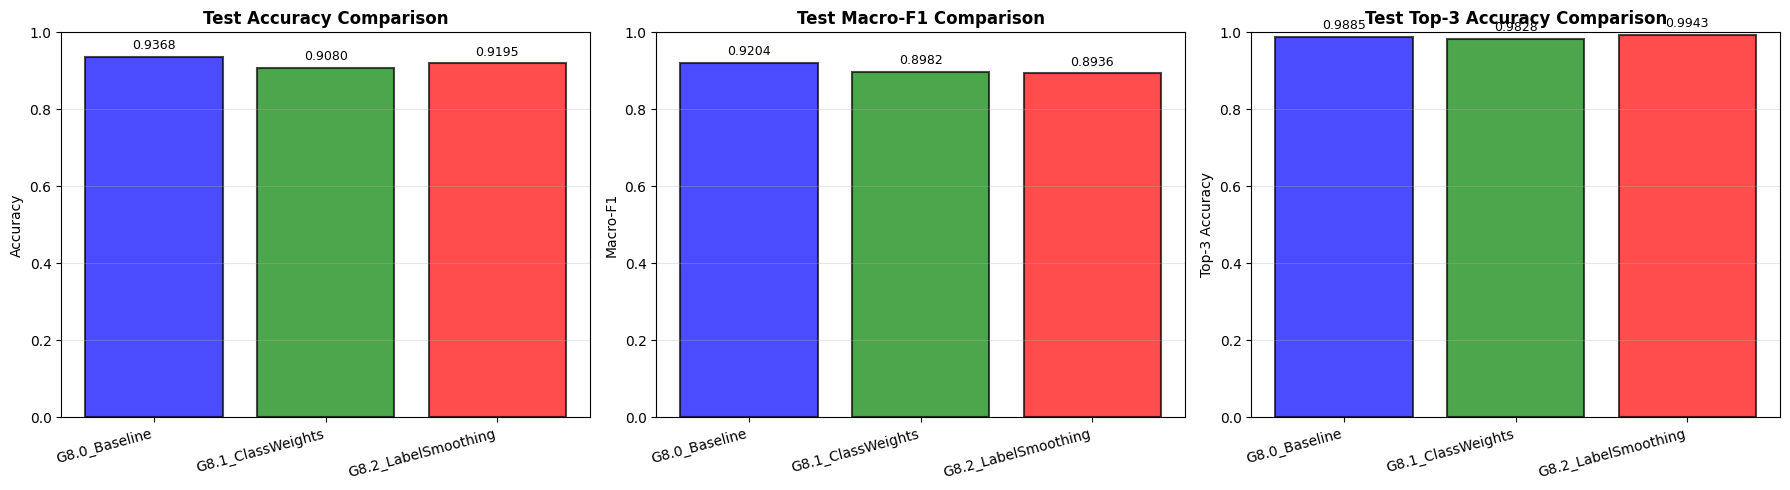

✓ Guardado: g8.0_embeddings\experiments_comparison_g8.csv

✓ Comparación de experimentos completada


In [ ]:
# Comparación de resultados Sequential Embeddings
all_results_emb = [exp0_results_emb, exp1_results_emb, exp2_results_emb]
df_comparison_emb = pd.DataFrame(all_results_emb)

print("\n" + "="*80)
print("TABLA COMPARATIVA DE EXPERIMENTOS SEQUENTIAL EMBEDDINGS")
print("="*80)
print(df_comparison_emb[['experiment', 'dropout', 'class_weights', 'label_smoothing', 
                          'test_accuracy', 'test_macro_f1', 'test_top3_accuracy']].to_string(index=False))

# Gráficos de comparación
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

experiments_names = df_comparison_emb['experiment'].values

# Accuracy
axes[0].bar(range(len(experiments_names)), df_comparison_emb['test_accuracy'], 
            color=['blue', 'green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(experiments_names)))
axes[0].set_xticklabels(experiments_names, rotation=15, ha='right')
axes[0].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_comparison_emb['test_accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=9)

# Macro-F1
axes[1].bar(range(len(experiments_names)), df_comparison_emb['test_macro_f1'], 
            color=['blue', 'green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(experiments_names)))
axes[1].set_xticklabels(experiments_names, rotation=15, ha='right')
axes[1].set_title('Test Macro-F1 Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Macro-F1')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_comparison_emb['test_macro_f1']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=9)

# Top-3 Accuracy
axes[2].bar(range(len(experiments_names)), df_comparison_emb['test_top3_accuracy'], 
            color=['blue', 'green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[2].set_xticks(range(len(experiments_names)))
axes[2].set_xticklabels(experiments_names, rotation=15, ha='right')
axes[2].set_title('Test Top-3 Accuracy Comparison', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Top-3 Accuracy')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_comparison_emb['test_top3_accuracy']):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=9)

plt.tight_layout()
comparison_plot_path = Path('./g8.0_embeddings/experiments_comparison_g8.png')
plt.savefig(comparison_plot_path, dpi=150, bbox_inches='tight')
print(f"\n✓ Guardado: {comparison_plot_path}")
plt.show()

# Guardar comparación en CSV
comparison_csv_path = Path('./g8.0_embeddings/experiments_comparison_g8.csv')
df_comparison_emb.to_csv(comparison_csv_path, index=False)
print(f"✓ Guardado: {comparison_csv_path}")

print("\n✓ Comparación de experimentos completada")